In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

In [2]:
%%capture
%matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Experiments
import run

In [3]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7f04e9b162e0>, <cadCAD.configuration.Configuration object at 0x7f04e9907040>, <cadCAD.configuration.Configuration object at 0x7f04e98faf40>, <cadCAD.configuration.Configuration object at 0x7f04e98fabe0>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f04e9b162e0>, <cadCAD.configuration.Configuration object at 0x7f04e9907040>, <cadCAD.configuration.Configuration object at 0x7f04e98faf40>, <cadCAD.configuration.Configuration object at 0x7f04e98fabe0>]
Execution in 0.3s


In [4]:
df = experiments.dataset[3]

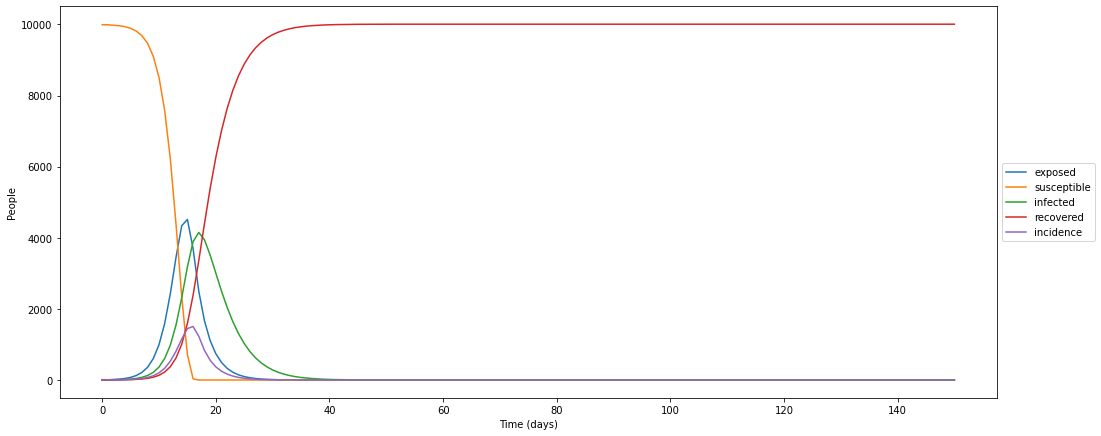

In [5]:
fig, ax = plt.subplots()
ax.plot(df['timestep'], df['exposed'], label='exposed')
ax.plot(df['timestep'], df['susceptible'], label='susceptible')
ax.plot(df['timestep'], df['infected'], label='infected'   )
ax.plot(df['timestep'], df['recovered'], label='recovered')
ax.plot(df['timestep'], df['incidence'], label='incidence')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 2.8, box.height * 1.8])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel("Time (days)")
ax.set_ylabel("People")
plt.show()

In [6]:
df

susceptible  exposed  infected  recovered  incidence  \
0         9990.0     10.0       0.0        0.0        0.0   
1         9990.0      6.0       4.0        0.0        4.0   
2         9978.0     16.0       5.0        1.0        2.0   
3         9963.0     25.0       9.0        3.0        6.0   
4         9936.0     43.0      15.0        6.0        9.0   
..           ...      ...       ...        ...        ...   
146          0.0      0.0       0.0    10006.0        0.0   
147          0.0      0.0       0.0    10006.0        0.0   
148          0.0      0.0       0.0    10006.0        0.0   
149          0.0      0.0       0.0    10006.0        0.0   
150          0.0      0.0       0.0    10006.0        0.0   

                                   reproductive_number  run  substep  timestep  
0    {'value': 3, 'r0': 0, 'K': 0, 'last_mutation':...    1        0         0  
1    {'value': 3, 'r0': 0, 'K': 0, 'last_mutation':...    1        1         1  
2    {'value': 3, 'r0': 0, 'K': 0, 'last_mutation':...    1        1         2  
3    {'value': 3, 'r0': 0, 'K': 0, 'last_mutation':...    1        1         3  
4    {'value': 3, 'r0': 0, 'K': 0, 'last_mutation':...    1        1         4  
..                                                 ...  ...      ...       ...  
146  {'value': 3, 'r0': 0, 'K': 0, 'last_mutation':...    1        1       146  
147  {'value': 3, 'r0': 0, 'K': 0, 'last_mutation':...    1        1       147  
148  {'value': 3, 'r0': 0, 'K': 0, 'last_mutation':...    1        1       148  
149  {'value': 3, 'r0': 0, 'K': 0, 'last_mutation':...    1        1       149  
150  {'value': 3, 'r0': 0, 'K': 0, 'last_mutation':...    1        1       150  

[151 rows x 9 columns]

In [7]:
incidence = df[['incidence']]
incidence['dates'] = df['timestep']
# incidence['timestep'] = incidence['timestep']+1
incidence.describe()

<ipython-input-7-b611ab0fcb20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incidence['dates'] = df['timestep']


incidence       dates
count   151.000000  151.000000
mean     66.264901   75.000000
std     243.637756   43.734045
min       0.000000    0.000000
25%       0.000000   37.500000
50%       0.000000   75.000000
75%       0.000000  112.500000
max    1506.000000  150.000000

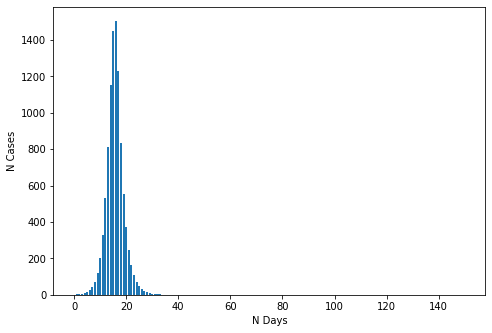

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('N Cases')
ax.set_xlabel('N Days')
ax.bar(incidence['dates'], incidence['incidence'])
plt.show()

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma


class ReproductionNumber:

    def __init__(self, incidence, prior_shape=1, prior_scale=5,
                 si_pmf=None, si_pars=None, t_start=None, window_width=None):
        """
        Initialize ReproductionNumber class
        :param incidence: pandas DataFrame with columns 'dates' and 'incidence' (number of new cases per day).
        :param prior_shape: value of shape parameter of Gamma prior for reproduction number estimation.
        :param prior_scale: value of scale parameter of Gamma prior for reproduction number estimation.
        :param si_pmf: pandas DataFrame with columns 'interval_length' and 'probability'.
        Represents probability mass function for given values of serial interval.
        :param si_pars: dictionary with keys 'mean' and 'sd'.
        Represents parameters to generate PMF for serial interval.
        """

        self.incidence = incidence.reset_index().set_index('dates')
        self.prior_shape = prior_shape
        self.prior_scale = prior_scale
        self.si_pmf = si_pmf
        self.si_pars = si_pars
        self.t_start = t_start
        self.window_width = window_width
        self.t_end = None
        self.posterior_parameters = {}
        self.posterior_summary = None
        self.check_time_periods()
        self.check_serial_number_pmf()

    def check_time_periods(self):
        if self.window_width is None:
            self.window_width = 6
        if self.t_start is None:
            self.t_start = np.arange(1, self.incidence.shape[0] - self.window_width)
        elif isinstance(self.t_start, list):
            self.t_start = np.array(self.t_start)
        self.t_end = self.t_start + self.window_width

    def check_serial_number_pmf(self):
        if self.si_pmf is not None and self.si_pars is not None:
            txt = "You must pass either 'si_pmf' or 'si_pars', not both."
            raise AttributeError(txt)
        if self.si_pmf is None:
            if self.si_pars is None:
                txt = "You must pass either 'si_pmf' or 'si_pars'. You've passed neither."
                raise AttributeError(txt)
            if not all([i in self.si_pars.keys() for i in ['mean', 'sd']]):
                txt = "'si_pars' must be a dictionary with 'mean' and 'sd' keys."
                raise AttributeError(txt)
            self.compute_serial_interval_pmf()
        else:
            self.si_pmf = self.si_pmf.reset_index().set_index('interval_length')['probability']

    def compute_serial_interval_pmf(self, k=None, mu=None, sigma=None):

        if k is None:
            k = np.arange(self.incidence.shape[0])
        elif not isinstance(k, np.ndarray):
            raise TypeError("k must be of type numpy.ndarray, probably shape = (n_time_windows, ).")

        if mu is None:
            mu = self.si_pars['mean']
        if sigma is None:
            sigma = self.si_pars['sd']

        if sigma < 0:
            raise AttributeError("sigma must be >=0.")
        if mu <= 1:
            raise AttributeError("mu must be >1")
        if not (k >= 0.).sum() == len(k):
            raise AttributeError("all values in k must be >=0.")

        shape = ((mu - 1) / sigma) ** 2
        scale = (sigma ** 2) / (mu - 1)

        def cdf_gamma(x, shape_, scale_):
            return gamma.cdf(x=x, a=shape_, scale=scale_)

        si_pmf = k * cdf_gamma(k,
                               shape,
                               scale) + (k - 2) * cdf_gamma(k - 2,
                                                            shape,
                                                            scale) - 2 * (k - 1) * cdf_gamma(k - 1,
                                                                                             shape,
                                                                                             scale)
        si_pmf = si_pmf + shape * scale * (2 * cdf_gamma(k - 1,
                                                         shape + 1,
                                                         scale) - cdf_gamma(k - 2,
                                                                            shape + 1,
                                                                            scale) - cdf_gamma(k,
                                                                                               shape + 1,
                                                                                               scale))
        si_pmf = np.array([np.max([0, i]) for i in si_pmf])

        self.si_pmf = si_pmf

    def compute_overall_infectivity(self):

        def fill_up_with_zeros(x, ref):
            x_nrows, ref_nrows = x.shape[0], ref.shape[0]
            updated_x = x
            if x_nrows < ref_nrows:
                updated_x = np.concatenate([x, np.zeros(1 + ref_nrows - x_nrows)])
            return updated_x

        incid, si_pmf = self.incidence, self.si_pmf
        si_pmf = fill_up_with_zeros(x=si_pmf, ref=incid)
        number_of_time_points = incid.shape[0]
        overall_infectivity = np.zeros((number_of_time_points,))
        for t in range(1, number_of_time_points + 1):
            overall_infectivity[t - 1] = (si_pmf[:t] * incid.iloc[:t][::-1]['incidence']).sum()
        overall_infectivity[0] = np.nan

        return overall_infectivity

    def compute_posterior_parameters(self, prior_shape=None, prior_scale=None):
        incid, si_pmf = self.incidence, self.si_pmf
        t_start, t_end = self.t_start, self.t_end
        if prior_shape is None:
            prior_shape = self.prior_shape
        if prior_scale is None:
            prior_scale = self.prior_scale

        number_of_time_windows = len(t_start)
        overall_infectivity = self.compute_overall_infectivity()
        final_mean_si = (si_pmf * range(len(si_pmf))).sum()

        posterior_shape = np.zeros(number_of_time_windows)
        posterior_scale = np.zeros(number_of_time_windows)

        for t in range(number_of_time_windows):
            if t_end[t] > final_mean_si:
                posterior_shape[t] = prior_shape + (incid.iloc[range(t_start[t], t_end[t] + 1)]["incidence"]).sum()
            else:
                posterior_shape[t] = np.nan

        for t in range(number_of_time_windows):
            if t_end[t] > final_mean_si:
                period_overall_infectivity = (overall_infectivity[range(t_start[t], t_end[t] + 1)]).sum()
                posterior_scale[t] = 1 / ((1 / prior_scale) + period_overall_infectivity)
            else:
                posterior_scale[t] = np.nan

        self.posterior_parameters['shape'] = posterior_shape
        self.posterior_parameters['scale'] = posterior_scale

    def sample_from_posterior(self, sample_size=1000):
        if not all([i in self.posterior_parameters.keys() for i in ['scale', 'shape']]):
            txt = "Can't sample from posterior before computing posterior parameters."
            raise IndexError(txt)
        posterior_shape = self.posterior_parameters['shape']
        posterior_scale = self.posterior_parameters['scale']
        number_of_time_windows = len(self.t_start)
        sample_r_posterior = np.zeros((number_of_time_windows, sample_size))
        for t in range(number_of_time_windows):
            if not t > len(posterior_shape) - 1:
                sample_r_posterior[t, ] = np.random.gamma(shape=posterior_shape[t],
                                                          scale=posterior_scale[t],
                                                          size=sample_size)
            else:
                sample_r_posterior[t,] = np.nan

        return sample_r_posterior.transpose()

    def compute_posterior_summaries(self, posterior_sample, t_max=None):
        start_dates = self.incidence.index[self.t_start]
        end_dates = self.incidence.index[self.t_end]
        post_mean_r = posterior_sample.mean(axis=0)
        post_sd = posterior_sample.std(axis=0)
        post_shape = self.posterior_parameters['shape']
        post_scale = self.posterior_parameters['scale']
        post_upper_quantile_r = np.quantile(posterior_sample, q=0.975, axis=0)
        post_lower_quantile_r = np.quantile(posterior_sample, q=0.025, axis=0)
        summary_dict = {
            'start_dates': start_dates, 'end_dates': end_dates,
            'Rt_mean': post_mean_r, 'Rt_sd': post_sd,
            'Rt_q0.975': post_upper_quantile_r, 'Rt_q0.025': post_lower_quantile_r,
            'Rt_shape': post_shape, 'Rt_scale': post_scale
        }
        posterior_summary = pd.DataFrame(summary_dict)
        posterior_summary['start_dates'] = posterior_summary['start_dates'].astype('datetime64[D]')
        posterior_summary['end_dates'] = posterior_summary['end_dates'].astype('datetime64[D]')

        if t_max is not None:
            last_day = max(posterior_summary['end_dates'])
            final_date = max(posterior_summary['end_dates']) + pd.Timedelta(days=t_max)
            last_day_data = posterior_summary[posterior_summary['end_dates'] == last_day].to_dict(orient='list')
            dates_ahead = pd.date_range(start=last_day, end=final_date)[1:]

            forecast_d = pd.DataFrame({
                'start_dates': pd.NaT, 'end_dates': dates_ahead
            })

            forecast_d['Rt_mean'] = last_day_data['Rt_mean'][0]
            forecast_d['Rt_sd'] = last_day_data['Rt_sd'][0]
            forecast_d['Rt_q0.975'] = last_day_data['Rt_q0.975'][0]
            forecast_d['Rt_q0.025'] = last_day_data['Rt_q0.025'][0]
            forecast_d['Rt_shape'] = last_day_data['Rt_shape'][0]
            forecast_d['Rt_scale'] = last_day_data['Rt_scale'][0]

            posterior_summary = pd.concat([posterior_summary, forecast_d], ignore_index=True)
            posterior_summary['estimation_type'] = np.where(posterior_summary['end_dates'] <= last_day,
                                                            'fitted', 'forecasted')

        self.posterior_summary = posterior_summary

    def plot_reproduction_number(self, title=None, filename=None):
        d = self.posterior_summary
        if d is None:
            txt = "You need to compute the summaries for the posterior distribution of Rt."
            raise ValueError(txt)
        if title is None:
            title = "R(t): time-varying reproduction number"
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(12, 5))
        plt.plot(d['end_dates'], d['Rt_mean'], color='b')
        plt.plot(d['end_dates'], [1] * len(d['Rt_mean']), color='gray', linestyle='dashed', alpha=0.75)
        plt.fill_between(d['end_dates'],
                         d['Rt_q0.975'],
                         d['Rt_q0.025'],
                         color='b', alpha=0.2)
        plt.title(title)
        plt.suptitle("$P(R_t | Data) \sim Gamma(k_t, \\theta_t)$")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        fig.autofmt_xdate()

        if 'estimation_type' in d.columns:
            plt.axvline(x=max(d[d['estimation_type'] == "fitted"]["end_dates"]),
                        color='gray', linestyle='dashed', alpha=0.75)

        if filename is None:
            plt.show()
        else:
            fig.savefig(filename, dpi=fig.dpi)
            plt.close()

## Doubths

- What are the mean and sd value? where they come from? They are the mean and std for a probality distribution of the incidences and dates?
- Compute overall infectivity gives me the high probability number of infected people in each day?
- How can i discover future 

## Understanding the attributes

- self.incidence = DataFrame that contains the columns Dates and Incidences. The column date its a type of time passed counter and Incidences is the number of new infecteds in that day.
- self.prior_shape =
- self.prior_scale =
- self.si_pmf = Probability mass functions of the 
- self.si_pars = 
- self.t_start = 
- self.window_width =
- self.t_end = 
- self.posterior_parameters = 
- self.posterior_summary = 
- self.check_time_periods()
- self.check_serial_number_pmf()

In [105]:
incidence[1:21]

incidence  dates
1         4.0      1
2         2.0      2
3         6.0      3
4         9.0      4
5        15.0      5
6        25.0      6
7        42.0      7
8        72.0      8
9       120.0      9
10      202.0     10
11      331.0     11
12      531.0     12
13      812.0     13
14     1152.0     14
15     1446.0     15
16     1506.0     16
17     1231.0     17
18      834.0     18
19      556.0     19
20      370.0     20

In [106]:
si_pars = {"mean": 4.7, "sd": 2.9}

test = ReproductionNumber(incidence=incidence[1:31], si_pars=si_pars)

In [107]:
print(len(test.si_pmf))
print(np.sum(test.si_pmf))
print(test.si_pmf)

30
0.9999793412396434
[0.000 0.057 0.178 0.185 0.156 0.121 0.090 0.065 0.046 0.032 0.022 0.015
 0.011 0.007 0.005 0.003 0.002 0.001 0.001 0.001 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000]


In [108]:
overall_infectivity = test.compute_overall_infectivity()
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(overall_infectivity)

[nan 0.226 0.825 1.437 2.571 4.357 7.287 12.171 20.458 34.512 58.053
 97.140 160.362 258.926 402.839 591.608 799.027 968.331 1043.528 1016.218
 919.901 790.407 653.661 525.086 412.261 317.767 241.267 180.860 134.172
 98.608]


In [109]:
test.compute_posterior_parameters()

In [110]:
r0 = test.sample_from_posterior()

In [111]:
r0[0:1000]

r0_df = pd.DataFrame(r0)

In [112]:
r0_df.describe()

0            1            2            3            4   \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      5.897332     5.880103     5.865010     5.792719     5.644651   
std       0.428390     0.344530     0.269776     0.210925     0.151671   
min       4.433647     4.867369     5.041005     5.133728     5.184803   
25%       5.613290     5.658038     5.678807     5.651082     5.549388   
50%       5.880603     5.860908     5.858860     5.790138     5.649188   
75%       6.192744     6.125909     6.042686     5.931659     5.742792   
max       7.212723     7.071193     6.880185     6.466576     6.230801   

                5            6            7            8            9   ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      5.411629     5.019705     4.450390     3.726349     2.958718  ...   
std       0.115669     0.088645     0.065310     0.049238     0.035074  ...   
min       5.052528     4.779782     4.239582     3.549166     2.839742  ...   
25%       5.335589     4.958158     4.407706     3.693146     2.933691  ...   
50%       5.417375     5.017877     4.451453     3.727205     2.959167  ...   
75%       5.495087     5.077135     4.493900     3.758130     2.982256  ...   
max       5.839449     5.310442     4.656428     3.890176     3.081994  ...   

                13           14           15           16           17  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      1.078077     0.801448     0.567426     0.398181     0.293214   
std       0.013819     0.011320     0.009794     0.007991     0.007210   
min       1.039000     0.758885     0.536295     0.375658     0.271663   
25%       1.068623     0.794372     0.560980     0.393041     0.288269   
50%       1.077942     0.802035     0.567435     0.398216     0.292876   
75%       1.087509     0.808740     0.573668     0.403512     0.297957   
max       1.117244     0.838669     0.607146     0.424207     0.316158   

                18           19           20           21           22  
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  
mean      0.226128     0.181135     0.149073     0.126191     0.108405  
std       0.006940     0.007120     0.007270     0.007133     0.007362  
min       0.206215     0.159385     0.126252     0.102295     0.086587  
25%       0.221368     0.175865     0.143920     0.121282     0.103455  
50%       0.225930     0.181047     0.148669     0.126303     0.108438  
75%       0.230664     0.185953     0.153865     0.130851     0.113274  
max       0.249939     0.203835     0.171613     0.153540     0.138679  

[8 rows x 23 columns]

In [113]:
test.compute_posterior_summaries(test.sample_from_posterior(), t_max=30)

In [114]:
test.posterior_summary

start_dates  end_dates   Rt_mean     Rt_sd  Rt_q0.975  Rt_q0.025  Rt_shape  \
0   1970-01-03 1970-01-09  5.912862  0.449932   6.899035   5.110599     172.0   
1   1970-01-04 1970-01-10  5.867291  0.354926   6.580824   5.201098     290.0   
2   1970-01-05 1970-01-11  5.867232  0.259940   6.376156   5.378556     486.0   
3   1970-01-06 1970-01-12  5.776180  0.201509   6.166528   5.381403     808.0   
4   1970-01-07 1970-01-13  5.646597  0.160701   5.956455   5.358781    1324.0   
5   1970-01-08 1970-01-14  5.412587  0.118398   5.642268   5.186005    2111.0   
6   1970-01-09 1970-01-15  5.019737  0.086848   5.191016   4.855188    3221.0   
7   1970-01-10 1970-01-16  4.450811  0.065563   4.575538   4.321801    4595.0   
8   1970-01-11 1970-01-17  3.733644  0.048907   3.831239   3.640380    5981.0   
9   1970-01-12 1970-01-18  2.960813  0.035220   3.029663   2.890469    7010.0   
10  1970-01-13 1970-01-19  2.292578  0.027512   2.344839   2.239251    7513.0   
11  1970-01-14 1970-01-20  1.785057  0.020907   1.826510   1.746139    7538.0   
12  1970-01-15 1970-01-21  1.396542  0.016352   1.427557   1.363638    7096.0   
13  1970-01-16 1970-01-22  1.078294  0.013555   1.104518   1.052321    6191.0   
14  1970-01-17 1970-01-23  0.801110  0.011209   0.822543   0.778479    4910.0   
15  1970-01-18 1970-01-24  0.567933  0.009732   0.586572   0.549911    3514.0   
16  1970-01-19 1970-01-25  0.397994  0.008228   0.414519   0.382184    2356.0   
17  1970-01-20 1970-01-26  0.293328  0.007490   0.308022   0.279445    1571.0   
18  1970-01-21 1970-01-27  0.226004  0.007173   0.240255   0.211513    1047.0   
19  1970-01-22 1970-01-28  0.181138  0.006832   0.194712   0.168015     699.0   
20  1970-01-23 1970-01-29  0.149467  0.006817   0.162471   0.136069     466.0   
21  1970-01-24 1970-01-30  0.126294  0.007053   0.140636   0.113167     311.0   
22  1970-01-25 1970-01-31  0.108116  0.007558   0.123286   0.093971     207.0   
23         NaT 1970-02-01  0.108116  0.007558   0.123286   0.093971     207.0   
24         NaT 1970-02-02  0.108116  0.007558   0.123286   0.093971     207.0   
25         NaT 1970-02-03  0.108116  0.007558   0.123286   0.093971     207.0   
26         NaT 1970-02-04  0.108116  0.007558   0.123286   0.093971     207.0   
27         NaT 1970-02-05  0.108116  0.007558   0.123286   0.093971     207.0   
28         NaT 1970-02-06  0.108116  0.007558   0.123286   0.093971     207.0   
29         NaT 1970-02-07  0.108116  0.007558   0.123286   0.093971     207.0   
30         NaT 1970-02-08  0.108116  0.007558   0.123286   0.093971     207.0   
31         NaT 1970-02-09  0.108116  0.007558   0.123286   0.093971     207.0   
32         NaT 1970-02-10  0.108116  0.007558   0.123286   0.093971     207.0   
33         NaT 1970-02-11  0.108116  0.007558   0.123286   0.093971     207.0   
34         NaT 1970-02-12  0.108116  0.007558   0.123286   0.093971     207.0   
35         NaT 1970-02-13  0.108116  0.007558   0.123286   0.093971     207.0   
36         NaT 1970-02-14  0.108116  0.007558   0.123286   0.093971     207.0   
37         NaT 1970-02-15  0.108116  0.007558   0.123286   0.093971     207.0   
38         NaT 1970-02-16  0.108116  0.007558   0.123286   0.093971     207.0   
39         NaT 1970-02-17  0.108116  0.007558   0.123286   0.093971     207.0   
40         NaT 1970-02-18  0.108116  0.007558   0.123286   0.093971     207.0   
41         NaT 1970-02-19  0.108116  0.007558   0.123286   0.093971     207.0   
42         NaT 1970-02-20  0.108116  0.007558   0.123286   0.093971     207.0   
43         NaT 1970-02-21  0.108116  0.007558   0.123286   0.093971     207.0   
44         NaT 1970-02-22  0.108116  0.007558   0.123286   0.093971     207.0   
45         NaT 1970-02-23  0.108116  0.007558   0.123286   0.093971     207.0   
46         NaT 1970-02-24  0.108116  0.007558   0.123286   0.093971     207.0   
47         NaT 1970-02-25  0.108116  0.007558   0.123286   0.093971     207.0   
48         NaT 1970-02-26  0.10811

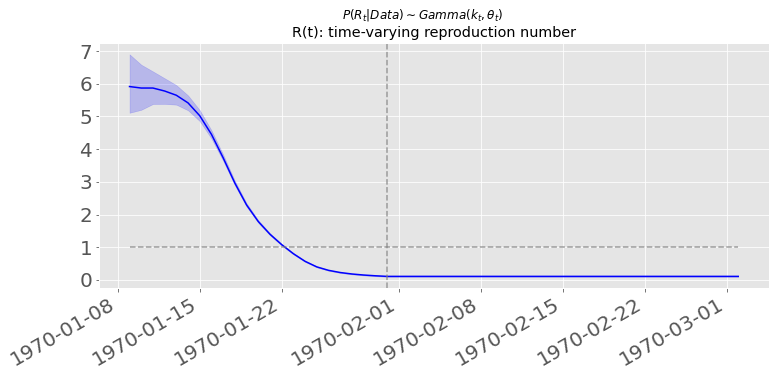

In [115]:
test.plot_reproduction_number()